In [62]:
import numpy as np

class MLP:
    def __init__(self, layer_sizes, activation=np.tanh, activation_deriv=lambda x: 1 - np.tanh(x)**2):
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.activation_deriv = activation_deriv
        self.weights = [np.random.randn(n_in, n_out) * np.sqrt(2. / n_in)
                        for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((1, n_out)) for n_out in layer_sizes[1:]]

    def __repr__(self):
        return f"MLP(layer_sizes={self.layer_sizes}, activation={self.activation.__name__})"

    def forward(self, X):
        activations = [X]
        zs = []
        for W, b in zip(self.weights, self.biases):
            z = activations[-1] @ W + b
            zs.append(z)
            activations.append(self.activation(z))
        return activations, zs

    def backward(self, X, y, lr=0.01):
        activations, zs = self.forward(X)
        grads_W = [np.zeros_like(W) for W in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]

        # Mean squared error loss and its derivative
        delta = (activations[-1] - y) * self.activation_deriv(zs[-1])
        grads_W[-1] = activations[-2].T @ delta
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

        for l in range(2, len(self.layer_sizes)):
            z = zs[-l]
            delta = (delta @ self.weights[-l+1].T) * self.activation_deriv(z)
            grads_W[-l] = activations[-l-1].T @ delta
            grads_b[-l] = np.sum(delta, axis=0, keepdims=True)

        # Update weights and biases
        for i in range(len(self.weights)):
            self.weights[i] -= lr * grads_W[i]
            self.biases[i] -= lr * grads_b[i]

    def train(self, X, y, epochs=100, lr=0.01):
        for epoch in range(epochs):
            self.backward(X, y, lr)

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1]
    

In [63]:

class MLPZeroInit:
    def __init__(self, layer_sizes, activation=np.tanh, activation_deriv=lambda x: 1 - np.tanh(x)**2):
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.activation_deriv = activation_deriv
        self.weights = [np.zeros((n_in, n_out))
                        for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((1, n_out)) for n_out in layer_sizes[1:]]

    def forward(self, X):
        activations = [X]
        zs = []
        for W, b in zip(self.weights, self.biases):
            z = activations[-1] @ W + b
            zs.append(z)
            activations.append(self.activation(z))
        return activations, zs

    def backward(self, X, y, lr=0.01):
        activations, zs = self.forward(X)
        grads_W = [np.zeros_like(W) for W in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]

        delta = (activations[-1] - y) * self.activation_deriv(zs[-1])
        grads_W[-1] = activations[-2].T @ delta
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

        for l in range(2, len(self.layer_sizes)):
            z = zs[-l]
            delta = (delta @ self.weights[-l+1].T) * self.activation_deriv(z)
            grads_W[-l] = activations[-l-1].T @ delta
            grads_b[-l] = np.sum(delta, axis=0, keepdims=True)

        for i in range(len(self.weights)):
            self.weights[i] -= lr * grads_W[i]
            self.biases[i] -= lr * grads_b[i]

    def train(self, X, y, epochs=100, lr=0.01):
        for epoch in range(epochs):
            self.backward(X, y, lr)

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1]

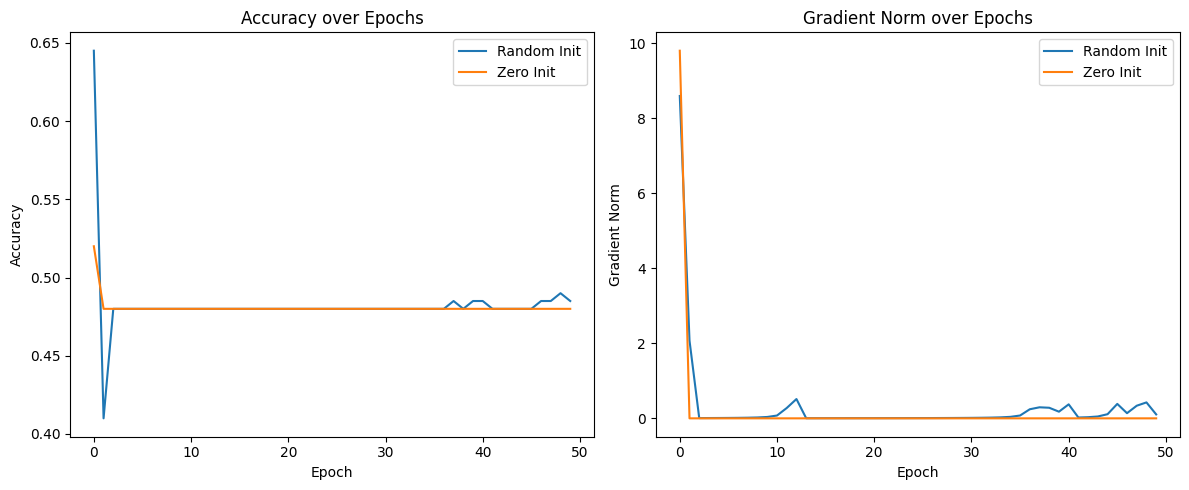

In [64]:
import matplotlib.pyplot as plt

# Generate synthetic data for a simple regression/classification problem
np.random.seed(42)
X = np.random.randn(200, 2)
y = (X[:, 0] * X[:, 1] > 0).astype(float).reshape(-1, 1)  # XOR-like pattern

# Helper to compute accuracy for binary classification
def accuracy(y_true, y_pred):
    return np.mean((y_pred > 0.5) == y_true)

# Train both models and record accuracy and gradient norms
mlp = MLP([2, 8, 1])
mlp_zero = MLPZeroInit([2, 8, 1])

epochs = 50
accs_mlp, accs_zero = [], []
grad_norms_mlp, grad_norms_zero = [], []

for epoch in range(epochs):
    # MLP with random init
    activations, zs = mlp.forward(X)
    y_pred = activations[-1]
    accs_mlp.append(accuracy(y, y_pred))
    # Compute gradient norm
    delta = (y_pred - y) * mlp.activation_deriv(zs[-1])
    grad_norms_mlp.append(np.linalg.norm(delta))
    mlp.backward(X, y, lr=0.1)

    # MLP with zero init
    activations_zero, zs_zero = mlp_zero.forward(X)
    y_pred_zero = activations_zero[-1]
    accs_zero.append(accuracy(y, y_pred_zero))
    delta_zero = (y_pred_zero - y) * mlp_zero.activation_deriv(zs_zero[-1])
    grad_norms_zero.append(np.linalg.norm(delta_zero))
    mlp_zero.backward(X, y, lr=0.1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(accs_mlp, label='Random Init')
plt.plot(accs_zero, label='Zero Init')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot gradient norms
plt.subplot(1, 2, 2)
plt.plot(grad_norms_mlp, label='Random Init')
plt.plot(grad_norms_zero, label='Zero Init')
plt.title('Gradient Norm over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()

plt.tight_layout()
plt.show()

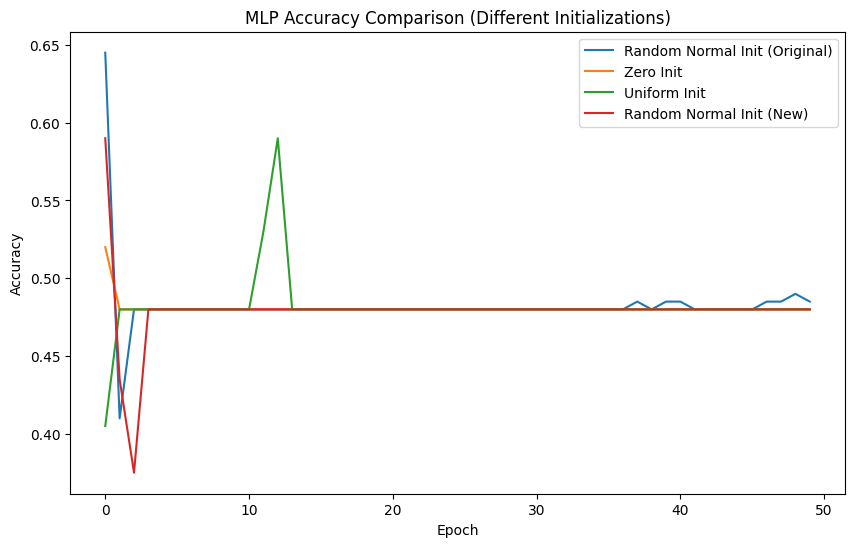

Best performing MLP: Random Normal Init (Original) with max accuracy 0.645


In [65]:
# Create two new MLPs: one with uniform random initialization, one with normal (already exists)
class MLPUniformInit:
    def __init__(self, layer_sizes, activation=np.tanh, activation_deriv=lambda x: 1 - np.tanh(x)**2):
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.activation_deriv = activation_deriv
        self.weights = [np.random.uniform(-1, 1, (n_in, n_out))
                        for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((1, n_out)) for n_out in layer_sizes[1:]]

    def forward(self, X):
        activations = [X]
        zs = []
        for W, b in zip(self.weights, self.biases):
            z = activations[-1] @ W + b
            zs.append(z)
            activations.append(self.activation(z))
        return activations, zs

    def backward(self, X, y, lr=0.01):
        activations, zs = self.forward(X)
        grads_W = [np.zeros_like(W) for W in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]

        delta = (activations[-1] - y) * self.activation_deriv(zs[-1])
        grads_W[-1] = activations[-2].T @ delta
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

        for l in range(2, len(self.layer_sizes)):
            z = zs[-l]
            delta = (delta @ self.weights[-l+1].T) * self.activation_deriv(z)
            grads_W[-l] = activations[-l-1].T @ delta
            grads_b[-l] = np.sum(delta, axis=0, keepdims=True)

        for i in range(len(self.weights)):
            self.weights[i] -= lr * grads_W[i]
            self.biases[i] -= lr * grads_b[i]

    def train(self, X, y, epochs=100, lr=0.01):
        for epoch in range(epochs):
            self.backward(X, y, lr)

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1]

# Instantiate the new MLPs
mlp_uniform = MLPUniformInit([2, 8, 1])
mlp_normal = MLP([2, 8, 1])  # Already uses normal distribution

# Helper to compute accuracy
def accuracy(y_true, y_pred):
    return np.mean((y_pred > 0.5) == y_true)

# Train all four MLPs and record accuracy
epochs = 50
accs_uniform, accs_normal = [], []
mlp_uniform_acc, mlp_normal_acc = [], []

for epoch in range(epochs):
    # Uniform init
    activations_uniform, zs_uniform = mlp_uniform.forward(X)
    y_pred_uniform = activations_uniform[-1]
    accs_uniform.append(accuracy(y, y_pred_uniform))
    mlp_uniform.backward(X, y, lr=0.1)

    # Normal init (fresh instance)
    activations_normal, zs_normal = mlp_normal.forward(X)
    y_pred_normal = activations_normal[-1]
    accs_normal.append(accuracy(y, y_pred_normal))
    mlp_normal.backward(X, y, lr=0.1)

# Plot all four
plt.figure(figsize=(10, 6))
plt.plot(accs_mlp, label='Random Normal Init (Original)')
plt.plot(accs_zero, label='Zero Init')
plt.plot(accs_uniform, label='Uniform Init')
plt.plot(accs_normal, label='Random Normal Init (New)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP Accuracy Comparison (Different Initializations)')
plt.legend()
plt.show()

# State which is best
best_accs = [max(accs_mlp), max(accs_zero), max(accs_uniform), max(accs_normal)]
best_idx = np.argmax(best_accs)
labels = ['Random Normal Init (Original)', 'Zero Init', 'Uniform Init', 'Random Normal Init (New)']
print(f"Best performing MLP: {labels[best_idx]} with max accuracy {best_accs[best_idx]:.3f}")

In [66]:
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable


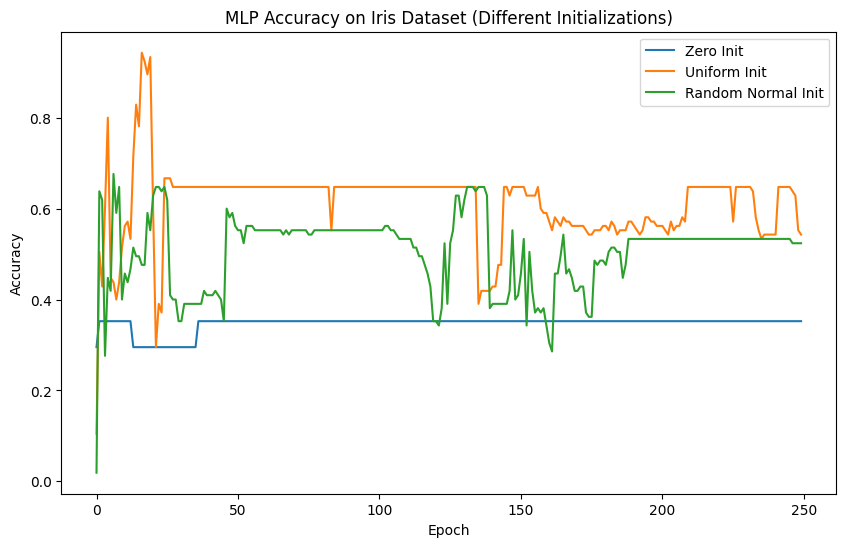

In [72]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Example: Use the Iris dataset from seaborn (commonly available on Kaggle)

# Load Iris dataset
iris = sns.load_dataset('iris')
X_iris = iris.drop('species', axis=1).values
y_iris = iris['species'].values

# Convert labels to one-hot encoding for MLP
lb = LabelBinarizer()
y_iris_onehot = lb.fit_transform(y_iris)

# Standardize features
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_iris_scaled, y_iris_onehot, test_size=0.3, random_state=42)

# Prepare MLPs for 4-class output
mlp_iris = MLP([4, 8, 3])
mlp_zero_iris = MLPZeroInit([4, 8, 3])
mlp_uniform_iris = MLPUniformInit([4, 8, 3])
mlp_normal_iris = MLP([4, 8, 3])

def accuracy_multi(y_true, y_pred):
    return (y_true.argmax(axis=1) == y_pred.argmax(axis=1)).mean()

epochs_iris = 250
accs_mlp_iris, accs_zero_iris, accs_uniform_iris, accs_normal_iris = [], [], [], []

for epoch in range(epochs_iris):
    # # MLP normal
    # y_pred = mlp_iris.predict(X_train)
    # accs_mlp_iris.append(accuracy_multi(y_train, y_pred))
    # mlp_iris.backward(X_train, y_train, lr=0.1)
    # MLP zero
    y_pred_zero = mlp_zero_iris.predict(X_train)
    accs_zero_iris.append(accuracy_multi(y_train, y_pred_zero))
    mlp_zero_iris.backward(X_train, y_train, lr=0.1)
    # MLP uniform
    y_pred_uniform = mlp_uniform_iris.predict(X_train)
    accs_uniform_iris.append(accuracy_multi(y_train, y_pred_uniform))
    mlp_uniform_iris.backward(X_train, y_train, lr=0.1)
    # MLP normal (fresh)
    y_pred_normal = mlp_normal_iris.predict(X_train)
    accs_normal_iris.append(accuracy_multi(y_train, y_pred_normal))
    mlp_normal_iris.backward(X_train, y_train, lr=0.1)

# Plot
plt.figure(figsize=(10, 6))
# plt.plot(accs_mlp_iris, label='Random Normal Init')
plt.plot(accs_zero_iris, label='Zero Init')
plt.plot(accs_uniform_iris, label='Uniform Init')
plt.plot(accs_normal_iris, label='Random Normal Init')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('MLP Accuracy on Iris Dataset (Different Initializations)')
plt.legend()
plt.show()

starting…
epoch 0
epoch 5
epoch 10
epoch 15
done loop


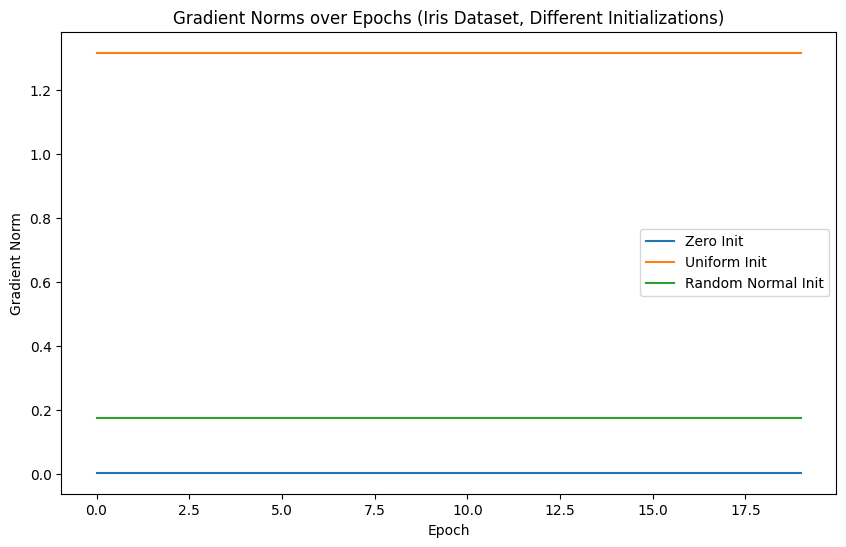

In [70]:
grad_norms_zero_iris, grad_norms_uniform_iris, grad_norms_normal_iris = [], [], []
print("starting…", flush=True)
for epoch in range(min(epochs_iris, 20)):
    _, zs_zero = mlp_zero_iris.forward(X_train)
    delta_zero = (mlp_zero_iris.predict(X_train) - y_train) * mlp_zero_iris.activation_deriv(zs_zero[-1])
    grad_norms_zero_iris.append(np.linalg.norm(delta_zero))

    _, zs_uniform = mlp_uniform_iris.forward(X_train)
    delta_uniform = (mlp_uniform_iris.predict(X_train) - y_train) * mlp_uniform_iris.activation_deriv(zs_uniform[-1])
    grad_norms_uniform_iris.append(np.linalg.norm(delta_uniform))

    _, zs_normal = mlp_normal_iris.forward(X_train)
    delta_normal = (mlp_normal_iris.predict(X_train) - y_train) * mlp_normal_iris.activation_deriv(zs_normal[-1])
    grad_norms_normal_iris.append(np.linalg.norm(delta_normal))

    if epoch % 5 == 0:
        print(f"epoch {epoch}", flush=True)
print("done loop", flush=True)

%matplotlib inline


plt.figure(figsize=(10, 6))
plt.plot(grad_norms_zero_iris, label='Zero Init')
plt.plot(grad_norms_uniform_iris, label='Uniform Init')
plt.plot(grad_norms_normal_iris, label='Random Normal Init')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms over Epochs (Iris Dataset, Different Initializations)')
plt.legend()
plt.show()

In [ ]:
# Compute and plot gradient norms over epochs for the Iris dataset using all three MLPs

grad_norms_zero_iris, grad_norms_uniform_iris, grad_norms_normal_iris = [], [], []

for epoch in range(epochs_iris):
    # Zero Init
    _, zs_zero = mlp_zero_iris.forward(X_train)
    delta_zero = (mlp_zero_iris.predict(X_train) - y_train) * mlp_zero_iris.activation_deriv(zs_zero[-1])
    grad_norms_zero_iris.append(np.linalg.norm(delta_zero))

    # Uniform Init
    _, zs_uniform = mlp_uniform_iris.forward(X_train)
    delta_uniform = (mlp_uniform_iris.predict(X_train) - y_train) * mlp_uniform_iris.activation_deriv(zs_uniform[-1])
    grad_norms_uniform_iris.append(np.linalg.norm(delta_uniform))

    # Normal Init
    _, zs_normal = mlp_normal_iris.forward(X_train)
    delta_normal = (mlp_normal_iris.predict(X_train) - y_train) * mlp_normal_iris.activation_deriv(zs_normal[-1])
    grad_norms_normal_iris.append(np.linalg.norm(delta_normal))

plt.figure(figsize=(10, 6))
plt.plot(grad_norms_zero_iris, label='Zero Init')
plt.plot(grad_norms_uniform_iris, label='Uniform Init')
plt.plot(grad_norms_normal_iris, label='Random Normal Init')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms over Epochs (Iris Dataset, Different Initializations)')
plt.legend()
plt.show()

In [ ]:
-- # Compute and plot gradient norms over epochs for the Iris dataset using all three MLPs

grad_norms_zero_iris, grad_norms_uniform_iris, grad_norms_normal_iris = [], [], []

for epoch in range(epochs_iris):
    -- # Zero Init
    _, zs_zero = mlp_zero_iris.forward(X_train)
    delta_zero = (mlp_zero_iris.predict(X_train) - y_train) * mlp_zero_iris.activation_deriv(zs_zero[-1])
    grad_norms_zero_iris.append(np.linalg.norm(delta_zero))

    -- # Uniform Init
    _, zs_uniform = mlp_uniform_iris.forward(X_train)
    delta_uniform = (mlp_uniform_iris.predict(X_train) - y_train) * mlp_uniform_iris.activation_deriv(zs_uniform[-1])
    grad_norms_uniform_iris.append(np.linalg.norm(delta_uniform))

    -- # Normal Init
    _, zs_normal = mlp_normal_iris.forward(X_train)
    delta_normal = (mlp_normal_iris.predict(X_train) - y_train) * mlp_normal_iris.activation_deriv(zs_normal[-1])
    grad_norms_normal_iris.append(np.linalg.norm(delta_normal))

plt.figure(figsize=(10, 6))
plt.plot(grad_norms_zero_iris, label='Zero Init')
plt.plot(grad_norms_uniform_iris, label='Uniform Init')
plt.plot(grad_norms_normal_iris, label='Random Normal Init')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms over Epochs (Iris Dataset, Different Initializations)')
plt.legend()
plt.show()

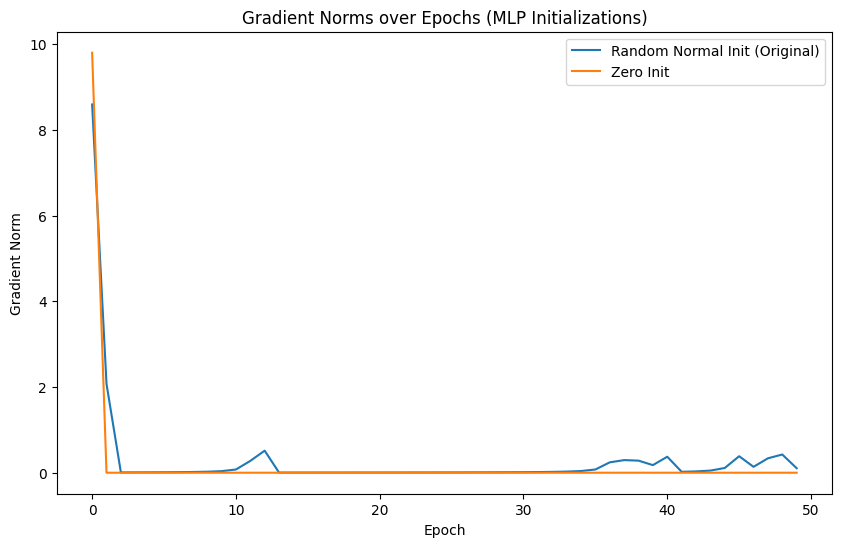

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(grad_norms_mlp, label='Random Normal Init (Original)')
plt.plot(grad_norms_zero, label='Zero Init')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms over Epochs (MLP Initializations)')
plt.legend()
plt.show()